# MNIST数据集：
0-9的手写数字图像，
每个数字有6,000个样本，一共有60,000张图片，
每个样本是28*28的灰度图像。
共有50,000个训练样本，10,000个测试样本。

# CIFAR-10数据集：
10个类别的RGB图像，
每个类别有6,000个样本，一共有60,000张图片，
每个样本是32*32的彩色图像。
共有50,000个训练样本，10,000个测试样本。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# <1> 数据集: MNIST, 归一化到[-1,1]之间
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# <2> 加载数据：分成小批次batch，打乱数据shuffle, 4个进程加载数据
train_loader = DataLoader(train_dataset, 
                          batch_size=32, # 一次加载32个样本, 最后一个不完整时，默认保留
                          shuffle=True, 
                          num_workers=4)  # 4个进程加载数据
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
all_targets = []
all_preds = []


100%|██████████| 9.91M/9.91M [05:17<00:00, 31.2kB/s]
  0%|          | 0.00/28.9k [00:00<?, ?B/s]

In [ ]:
# <3> 定义模型
model = nn.Sequential(
    nn.Conv2d(1,              # 输入通道数
              6,              # 输出通道数
              kernel_size=5,  # 卷积核大小，5x5
              stride=1,       # 步长
              padding=2),     # 填充           权值数量为1*5*5*6+6=156
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),     # 权值数量为0 # 平均池化改为最大池化，权值数量不变 
    nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0), # 输入通道数6，输出通道数16，卷积核大小5x5，权值数量为6*5*5*16+16=2416
    nn. ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0), 
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), # 全连接层，输入维度16*5*5，输出维度120，权值数量为16*5*5*120+120=48120
    nn.ReLU(),
    nn.Linear(120, 84),   # 全连接层，输入维度120，输出维度84，权值数量为120*84+84=10164   
    nn.ReLU(), # 增加一个ReLU激活函数
    nn.Linear(84, 10)   )       # 全连接层，输入维度84，输出维度10，权值数量为10*84+10=850
# 模型全部参数数量=156+2416+48120+10164+850=61706

In [ ]:
# 使用 He 初始化
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

model.apply(weights_init)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# 显示网络结构

# pip install torchsummary
import torchsummary

# 显示每一层的输出形状，参数数量，总参数数量
torchsummary.summary(
    model,
    (1, 28, 28) ,  # 补充信息：输入维度(通道数，高，宽)
    device="cpu" ) # 默认为cuda

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [ ]:
# <4> 损失函数、优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# <5> 训练模型
for epoch in range(20):
    total_loss = 0
    model.train()
    for data, target in train_loader: 
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    print(f'Epoch {epoch+1}, Avg Loss: {avg_loss}')

Epoch 1, Loss: 0.27205589413642883
Epoch 1, Avg Loss: 0.19542235014963275
Epoch 2, Loss: 0.18465794622898102
Epoch 2, Avg Loss: 0.1264794265280439
Epoch 3, Loss: 0.007660816423594952
Epoch 3, Avg Loss: 0.11437709715899545
Epoch 4, Loss: 0.016402101144194603
Epoch 4, Avg Loss: 0.11232297072163007
Epoch 5, Loss: 0.015418348833918571
Epoch 5, Avg Loss: 0.11482162165602713
Epoch 6, Loss: 0.06852147728204727
Epoch 6, Avg Loss: 0.11830504745783595
Epoch 7, Loss: 0.02118721976876259
Epoch 7, Avg Loss: 0.1167695670236717
Epoch 8, Loss: 0.06194058805704117
Epoch 8, Avg Loss: 0.11256945741434138
Epoch 9, Loss: 0.00664948858320713
Epoch 9, Avg Loss: 0.11542430402753452
Epoch 10, Loss: 0.008809086866676807
Epoch 10, Avg Loss: 0.11489143299423461


In [ ]:
# <6> 测试模型
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
    
        all_targets.extend(target.numpy())
        all_preds.extend(predicted.numpy())
print(f'精度: {100 * correct / total}%')

精度: 97.98%


[[ 965    6    0    1    1    0    5    1    1    0]
 [   0 1129    0    1    1    0    0    2    1    1]
 [   4    4 1016    0    2    0    0    6    0    0]
 [   0    2    6  986    1    5    0    4    5    1]
 [   0    1    0    0  980    0    0    0    0    1]
 [   0    2    0    0    2  873    1    1    9    4]
 [   5   12    0    0    7    3  924    0    7    0]
 [   0    8    4    0    2    1    0 1007    0    6]
 [   4    8    3    1    2    3    0    1  944    8]
 [   0    0    0    0   25    3    0    3    4  974]]


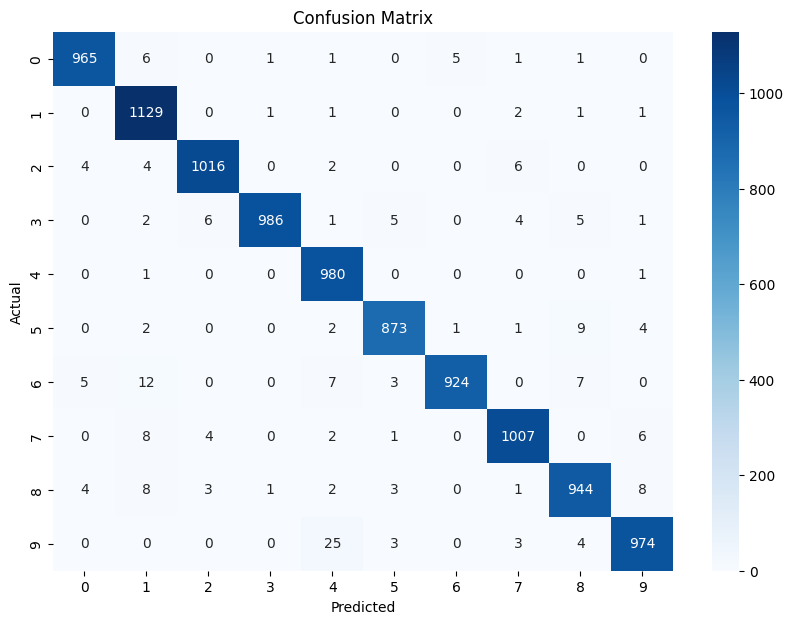

              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.99       980
     Class 1       0.96      0.99      0.98      1135
     Class 2       0.99      0.98      0.99      1032
     Class 3       1.00      0.98      0.99      1010
     Class 4       0.96      1.00      0.98       982
     Class 5       0.98      0.98      0.98       892
     Class 6       0.99      0.96      0.98       958
     Class 7       0.98      0.98      0.98      1028
     Class 8       0.97      0.97      0.97       974
     Class 9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
# 假设 target 和 predicted 已经定义并包含数据
# target = ...
# predicted = ...

# 计算混淆矩阵
cm = confusion_matrix(all_targets, all_preds)
print(cm)
#
# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
report = classification_report(all_targets, all_preds, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9'])
print(report)

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# 1. 加载图片
image_path =  r"C:\Users\-吕继亮\Desktop\手写数字识别.jpg"  # 替换为你的图片路径
image_path1 =  r"C:\Users\-吕继亮\Desktop\手写数字9.jpg"  # 替换为你的图片路径
image = Image.open(image_path)
image1 = Image.open(image_path1)
# 2. 转换为灰度图
image = image.convert("L")
image1 = image1.convert("L")
# 3. 调整大小为28x28像素
image = image.resize((28, 28))
image1 = image1.resize((28, 28))
# 4. 反转颜色（确保黑底白字，如果原图是白底黑字则需反转）
image = Image.eval(image, lambda x: 255 - x)  # 根据实际颜色调整
image1 = Image.eval(image1, lambda x: 255 - x)  # 根据实际颜色调整
# 5. 转换为PyTorch张量并归一化（与MNIST一致）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 归一化到[-1,1]
])
image_tensor = transform(image).unsqueeze(0)  # 添加batch维度 -> [1, 1, 28, 28]
image_tensor1 = transform(image1).unsqueeze(0)  # 添加batch维度 -> [1, 1, 28, 28]
# 6. 显示图片
print(image_tensor.shape)  # 应为 torch.Size([1, 1, 28, 28])
print(image_tensor1.shape)  # 应为 torch.Size([1, 1, 28, 28])

torch.Size([1, 1, 28, 28])


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image_tensor1.squeeze().numpy(), cmap="gray")
plt.show()

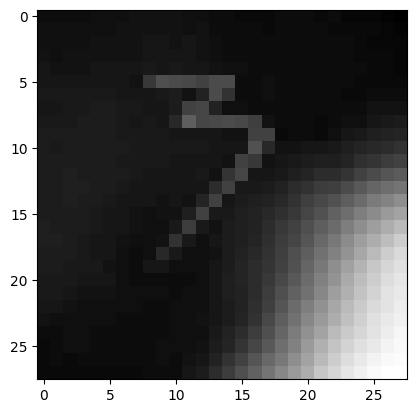

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image_tensor.squeeze().numpy(), cmap="gray")
plt.show()

In [ ]:
# ...（之前的预处理代码保持不变）...

# 执行预测
with torch.no_grad():
    output = model(image_tensor)
    output1 = model(image_tensor1)
# 获取预测概率（新增softmax处理）
probabilities = torch.nn.functional.softmax(output[0], dim=0)
probabilities1 = torch.nn.functional.softmax(output1[0], dim=0)
# 打印所有类别的概率值（新增）
print("预测概率分布：")
for i, prob in enumerate(probabilities):
    print(f"数字 {i}: {prob*100:.2f}%")
for i, prob in enumerate(probabilities1):
    print(f"数字 {i}: {prob*100:.2f}%")
# 获取最终预测结果（原代码）
predicted = torch.argmax(probabilities).item()
predicted1 = torch.argmax(probabilities1).item()
print(f"\n最终预测结果：{predicted}")
print(f"\n最终预测结果：{predicted1}")

In [ ]:
input_tensor = transform(image).unsqueeze(0)
output = model(input_tensor)
predicted = torch.argmax(output).item()
print(f"Predicted: {predicted}")

Predicted: 1
